# Bayesian Poisson Regression
This notebook is ported from the [example notebook](https://docs.pymc.io/notebooks/GLM-poisson-regression.html) of PyMC3 on Poisson Regression.  

[Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression) is a technique commonly used to model count data. Some of the applications include predicting the number of people defaulting on their loans or the number of cars running on a highway on a given day. This example describes a method to implement the Bayesian version of this technique using Turing.

We will generate the dataset that we will be working on which describes the relationship between number of times a person sneezes during the day with his alcohol consumption and medicinal intake.

We start by importing the required libraries.

In [1]:
#Import Turing, Distributions and DataFrames
using Turing, Distributions, DataFrames, Distributed

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.setprogress!(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/dtolpin/.julia/packages/Turing/PyTy2/src/Turing.jl:30
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/dtolpin/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:15


false

# Generating data
We start off by creating a toy dataset. We take the case of a person who takes medicine to prevent excessive sneezing. Alcohol consumption increases the rate of sneezing for that person. Thus, the two factors affecting the number of sneezes in a given day are alcohol consumption and whether the person has taken his medicine. Both these variable are taken as boolean valued while the number of sneezes will be a count valued variable. We also take into consideration that the interaction between the two boolean variables will affect the number of sneezes

5 random rows are printed from the generated data to get a gist of the data generated.

In [2]:
theta_noalcohol_meds = 1    # no alcohol, took medicine
theta_alcohol_meds = 3      # alcohol, took medicine
theta_noalcohol_nomeds = 6  # no alcohol, no medicine
theta_alcohol_nomeds = 36   # alcohol, no medicine

# no of samples for each of the above cases
q = 100

#Generate data from different Poisson distributions
noalcohol_meds = Poisson(theta_noalcohol_meds)
alcohol_meds = Poisson(theta_alcohol_meds)
noalcohol_nomeds = Poisson(theta_noalcohol_nomeds)
alcohol_nomeds = Poisson(theta_alcohol_nomeds)

nsneeze_data = vcat(rand(noalcohol_meds, q), rand(alcohol_meds, q), rand(noalcohol_nomeds, q), rand(alcohol_nomeds, q) )
alcohol_data = vcat(zeros(q), ones(q), zeros(q), ones(q) )
meds_data = vcat(zeros(q), zeros(q), ones(q), ones(q) )

df = DataFrame(nsneeze = nsneeze_data, alcohol_taken = alcohol_data, nomeds_taken = meds_data, product_alcohol_meds = meds_data.*alcohol_data)
df[sample(1:nrow(df), 5, replace = false), :]

,nsneeze,alcohol_taken,nomeds_taken,product_alcohol_meds
,Int64,Float64,Float64,Float64
1,1,1.0,0.0,0.0
2,4,0.0,1.0,0.0
3,0,0.0,0.0,0.0
4,1,0.0,0.0,0.0
5,0,0.0,0.0,0.0


# Visualisation of the dataset
We plot the distribution of the number of sneezes for the 4 different cases taken above. As expected, the person sneezes the most when he has taken alcohol and not taken his medicine. He sneezes the least when he doesn't consume alcohol and takes his medicine.

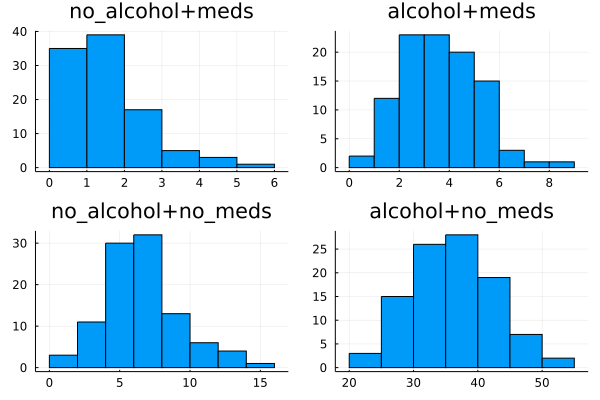

In [3]:
#Data Plotting

p1 = Plots.histogram(df[(df[:,:alcohol_taken] .== 0) .& (df[:,:nomeds_taken] .== 0), 1], title = "no_alcohol+meds")  
p2 = Plots.histogram((df[(df[:,:alcohol_taken] .== 1) .& (df[:,:nomeds_taken] .== 0), 1]), title = "alcohol+meds")  
p3 = Plots.histogram((df[(df[:,:alcohol_taken] .== 0) .& (df[:,:nomeds_taken] .== 1), 1]), title = "no_alcohol+no_meds")  
p4 = Plots.histogram((df[(df[:,:alcohol_taken] .== 1) .& (df[:,:nomeds_taken] .== 1), 1]), title = "alcohol+no_meds")  
plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

We must convert our `DataFrame` data into the `Matrix` form as the manipulations that we are about are designed to work with `Matrix` data. We also separate the features from the labels which will be later used by the Turing sampler to generate samples from the posterior.

In [4]:
# Convert the DataFrame object to matrices.
data = Matrix(df[:,[:alcohol_taken, :nomeds_taken, :product_alcohol_meds]])
data_labels = df[:,:nsneeze]
data

400×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

We must recenter our data about 0 to help the Turing sampler in initialising the parameter estimates. So, normalising the data in each column by subtracting the mean and dividing by the standard deviation:

In [5]:
# # Rescale our matrices.
data = (data .- mean(data, dims=1)) ./ std(data, dims=1)

400×3 Array{Float64,2}:
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
 -0.998749  -0.998749  -0.576628
  ⋮                    
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988
  0.998749   0.998749   1.72988

# Declaring the Model: Poisson Regression
Our model, `poisson_regression` takes four arguments:

- `x` is our set of independent variables;
- `y` is the element we want to predict;
- `n` is the number of observations we have; and
- `σ²` is the standard deviation we want to assume for our priors.

Within the model, we create four coefficients (`b0`, `b1`, `b2`, and `b3`) and assign a prior of normally distributed with means of zero and standard deviations of `σ²`. We want to find values of these four coefficients to predict any given `y`. 

Intuitively, we can think of the coefficients as:

- `b1` is the coefficient which represents the effect of taking alcohol on the number of sneezes; 
- `b2` is the coefficient which represents the effect of taking in no medicines on the number of sneezes; 
- `b3` is the coefficient which represents the effect of interaction between taking alcohol and no medicine on the number of sneezes; 

The `for` block creates a variable `theta` which is the weighted combination of the input features. We have defined the priors on these weights above. We then observe the likelihood of calculating `theta` given the actual label, `y[i]`.

In [6]:
# Bayesian poisson regression (LR)
@model poisson_regression(x, y, n, σ²) = begin
    b0 ~ Normal(0, σ²)
    b1 ~ Normal(0, σ²)
    b2 ~ Normal(0, σ²)
    b3  ~ Normal(0, σ²)
    for i = 1:n
        theta = b0 + b1*x[i, 1] + b2*x[i,2] + b3*x[i,3]
        y[i] ~ Poisson(exp(theta))
    end
end;

# Sampling from the posterior
We use the `NUTS` sampler to sample values from the posterior. We run multiple chains using the `mapreduce` function to nullify the effect of a problematic chain. We then use the Gelman, Rubin, and Brooks Diagnostic to check the convergence of these multiple chains.

In [7]:
# Retrieve the number of observations.
n, _ = size(data)

# Sample using NUTS.

num_chains = 4
chain = mapreduce(
    c -> sample(poisson_regression(data, data_labels, n, 10), NUTS(200, 0.65), 2500, discard_adapt=false), 
    chainscat, 
    1:num_chains);

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/dtolpin/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/dtolpin/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/dtolpin/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/dtolpin/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/dtolpin/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/dtolpin/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188


# Viewing the Diagnostics 
We use the Gelman, Rubin, and Brooks Diagnostic to check whether our chains have converged. Note that we require multiple chains to use this diagnostic which analyses the difference between these multiple chains. 

We expect the chains to have converged. This is because we have taken sufficient number of iterations (1500) for the NUTS sampler. However, in case the test fails, then we will have to take a larger number of iterations, resulting in longer computation time.

In [8]:
gelmandiag(chain)

Gelman, Rubin, and Brooks Diagnostic
  parameters      psrf     97.5% 
      Symbol   Float64   Float64 

          b0    1.1771    1.2032
          b1    1.0346    1.0521
          b2    1.0637    1.0834
          b3    1.0376    1.0534


From the above diagnostic, we can conclude that the chains have converged because the PSRF values of the coefficients are close to 1. 

So, we have obtained the posterior distributions of the parameters. We transform the coefficients and recover theta values by taking the exponent of the meaned values of the coefficients `b0`, `b1`, `b2` and `b3`. We take the exponent of the means to get a better comparison of the relative values of the coefficients. We then compare this with the intuitive meaning that was described earlier. 

In [9]:
# Taking the first chain
c1 = chain[:,:,1]

# Calculating the exponentiated means
b0_exp = exp(mean(c1[:b0]))
b1_exp = exp(mean(c1[:b1]))
b2_exp = exp(mean(c1[:b2]))
b3_exp = exp(mean(c1[:b3]))

print("The exponent of the mean values of the weights (or coefficients are): \n")
print("b0: ", b0_exp, " \n", "b1: ", b1_exp, " \n", "b2: ", b2_exp, " \n", "b3: ", b3_exp, " \n")
print("The posterior distributions obtained after sampling can be visualised as :\n")

The exponent of the mean values of the weights (or coefficients are): 
b0: 5.1494050804971865 
b1: 1.7553899550507814 
b2: 2.439453306056932 
b3: 1.3236043417620436 
The posterior distributions obtained after sampling can be visualised as :


 Visualising the posterior by plotting it:

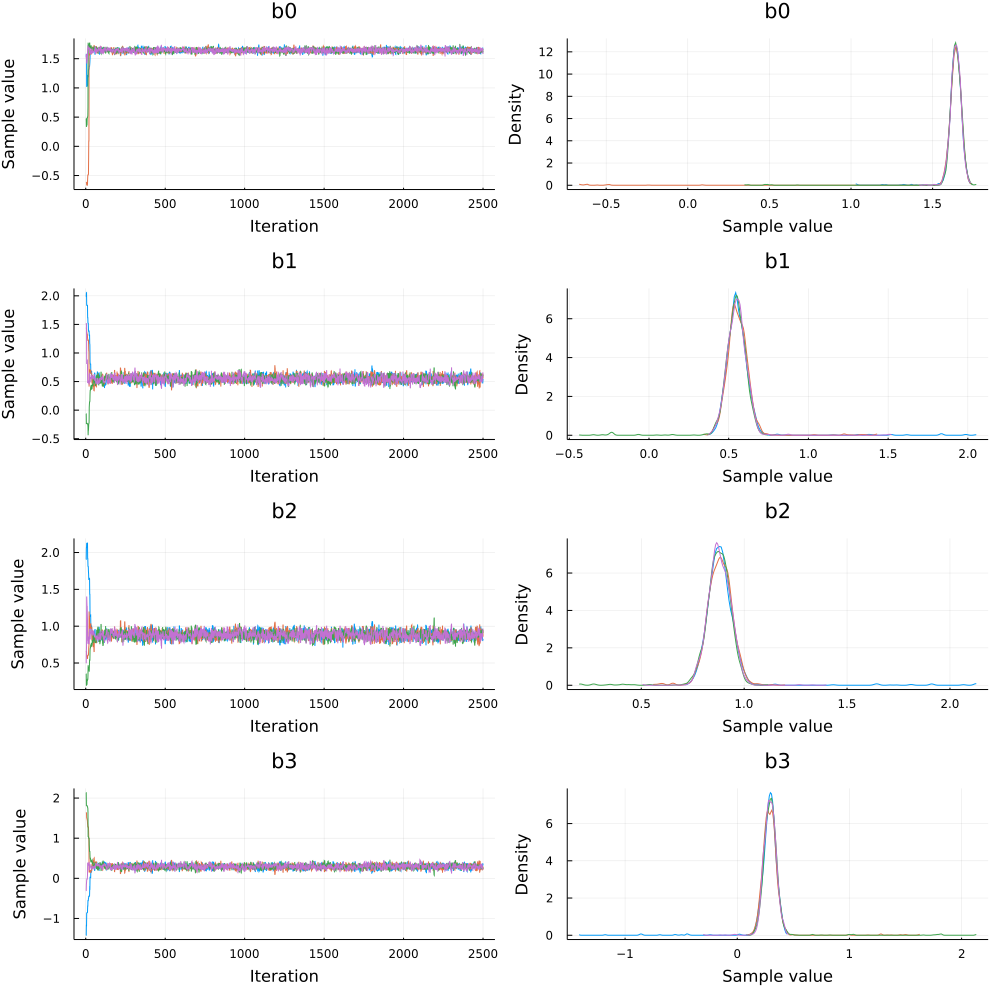

In [10]:
plot(chain)

# Interpreting the Obtained Mean Values
The exponentiated mean of the coefficient `b1` is roughly half of that of `b2`. This makes sense because in the data that we generated, the number of sneezes was more sensitive to the medicinal intake as compared to the alcohol consumption. We also get a weaker dependence on the interaction between the alcohol consumption and the medicinal intake as can be seen from the value of `b3`.

# Removing the Warmup Samples

As can be seen from the plots above, the parameters converge to their final distributions after a few iterations. These initial values during the warmup phase increase the standard deviations of the parameters and are not required after we get the desired distributions. Thus, we remove these warmup values and once again view the diagnostics. 

To remove these warmup values, we take all values except the first 200. This is because we set the second parameter of the NUTS sampler (which is the number of adaptations) to be equal to 200. `describe(chain)` is used to view the standard deviations in the estimates of the parameters. It also gives other useful information such as the means and the quantiles.

In [11]:
# Note the standard deviation before removing the warmup samples
dsc = describe(chain)
dsc[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

          b0    1.6359    0.1124     0.0011    0.0046   549.0561    1.0059
          b1    0.5537    0.0971     0.0010    0.0042   510.1076    1.0080
          b2    0.8816    0.0802     0.0008    0.0034   526.2135    1.0062
          b3    0.2938    0.1115     0.0011    0.0050   450.8996    1.0071


In [12]:
dsc[2]

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          b0    1.5781    1.6220    1.6427    1.6636    1.7021
          b1    0.4372    0.5121    0.5499    0.5899    0.6677
          b2    0.7726    0.8443    0.8800    0.9175    0.9868
          b3    0.1848    0.2553    0.2924    0.3279    0.4007


In [13]:
# Removing the first 200 values of the chains.
chains_new = chain[201:2500,:,:]
dsc = describe(chains_new)
dsc[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          b0    1.6426    0.0302     0.0003    0.0006   3097.2762    1.0006
          b1    0.5514    0.0563     0.0006    0.0011   2552.1180    1.0009
          b2    0.8815    0.0525     0.0005    0.0011   2417.2678    1.0011
          b3    0.2911    0.0524     0.0005    0.0010   2507.8309    1.0011


In [14]:
dsc[2]

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          b0    1.5824    1.6223    1.6426    1.6633    1.7017
          b1    0.4422    0.5131    0.5502    0.5898    0.6625
          b2    0.7783    0.8457    0.8806    0.9176    0.9837
          b3    0.1893    0.2552    0.2918    0.3265    0.3940


Visualising the new posterior by plotting it:

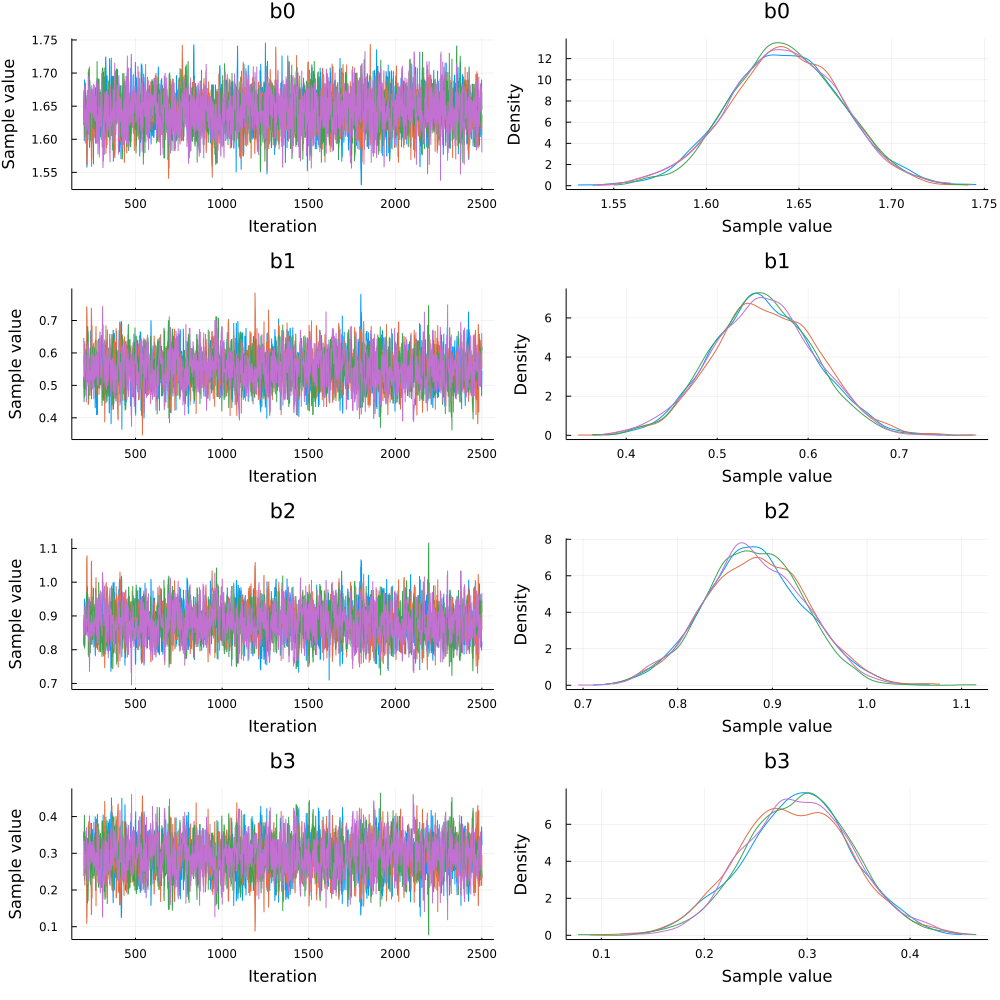

In [15]:
plot(chains_new)

As can be seen from the numeric values and the plots above, the standard deviation values have decreased and all the plotted values are from the estimated posteriors. The exponentiated mean values, with the warmup samples removed, have not changed by much and they are still in accordance with their intuitive meanings as described earlier.